**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm和岭回归为例), 并将模型加权组合成混合模型  

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 以沪深300数据集为例，构建特征和目标值，拟合特征与目标值，并评估模型
# 数据已经经过了初步清洗，剔除掉每天的涨跌停股和ST股，并使用后复权价格
# 如果不做回测，可以注释掉一切带"_test"的行

import pandas as pd
from scutquant import scutquant, alpha

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)

#sup_data = pd.read_csv('D:/Desktop/SH000300.csv')  # supplemental_data
#df = scutquant.join_data(df, sup_data, time='datetime', col=['idx_close'], index=['datetime', 'instrument'])  
df

open       close        high         low  \
datetime   instrument                                                   
2010-01-04 300003.SZ    51.590000   51.500000   51.850000   51.100000   
           300014.SZ    39.700000   39.470000   39.900000   39.240000   
           300015.SZ    48.970000   48.770000   49.190000   48.550000   
           300033.SZ    72.010000   74.570000   76.060000   71.610000   
           600000.SH    64.829142   62.928517   64.947931   62.839425   
...                           ...         ...         ...         ...   
2022-12-23 688363.SH   130.338644  130.842543  133.513211  129.078895   
           688396.SH    53.248294   52.735905   54.052042   52.344078   
           688561.SH    61.590000   67.160000   68.190000   61.590000   
           688599.SH    55.856185   54.938671   56.263968   53.909017   
           688981.SH    40.900000   41.060000   41.330000   40.830000   

                           volume        amount  
datetime   instrument                            
2010-01-04 300003.SZ     842437.0  4.328901e+07  
           300014.SZ     727706.0  2.873182e+07  
           300015.SZ     740314.0  3.613862e+07  
           300033.SZ    3627417.0  2.702477e+08  
           600000.SH   66191338.0  1.419984e+09  
...                           ...           ...  
2022-12-23 688363.SH    2334792.0  3.036193e+08  
           688396.SH    3462319.0  1.820840e+08  
           688561.SH    3554834.0  2.353862e+08  
           688599.SH   10072858.0  5.395502e+08  
           688981.SH    7428877.0  3.055459e+08  

[651282 rows x 6 columns]

In [3]:
# 清洗数据(由于原始数据已经经过了初步清洗，所以以下步骤可以省去)

# 查看缺失值和数据类型
df.info()
# 查看是否存在异常数据
#df.describe()
# 处理缺失值
#df.dropna(axis=1, how='all', inplace=True)  # 去除掉全为缺失值的列
#df = df.groupby(['instrument']).fillna(method='ffill').dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 651282 entries, ('2010-01-04', '300003.SZ') to ('2022-12-23', '688981.SH')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    651282 non-null  float64
 1   close   651282 non-null  float64
 2   high    651282 non-null  float64
 3   low     651282 non-null  float64
 4   volume  651282 non-null  float64
 5   amount  651282 non-null  float64
dtypes: float64(6)
memory usage: 32.4+ MB


**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 因子的构建方法有很多种, 关于因子可以查看alpha模块的注释以及量协的各种资料. 但我们在这里仅使用原始数据的0~59阶滞后项构建因子，让模型从它们张成的360维空间中寻找有用的信息预测目标值(可以跟tutorial(dnn)作比较)

In [4]:
# 下面开始构造目标值和特征

df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'open': 'open',
    'close': 'close',
    'high': 'high',
    'low': 'low',
    'volume': 'volume',
    'amount': 'amount',
    'groupby': 'instrument'
}
features = alpha.alpha360(feature_kwargs, shift=60)  # 请使用自己的因子库以获得更好的表现
X = pd.concat([features, df['label']], axis=1)

# 伪市场因子,需要读取supplemental data
#df['idx_ret'] = scutquant.price2ret(df['idx_close'], shift1=1, shift2=0, groupby='instrument')
#X['market'] = df['idx_ret'] / df['close']
X.describe()

,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60,label
count,650972.000000,650662.000000,650352.000000,650042.000000,649732.000000,649422.000000,649112.000000,648802.000000,648492.000000,648182.000000,...,6.351620e+05,6.348520e+05,6.345420e+05,6.342320e+05,6.339220e+05,6.336120e+05,6.333020e+05,6.329920e+05,6.326820e+05,650662.000000
mean,0.999646,0.999795,0.999904,1.000015,1.000095,1.000132,1.000170,1.000211,1.000241,1.000267,...,1.977042e+07,1.978518e+07,1.980294e+07,1.981681e+07,1.982939e+07,1.984122e+07,1.985193e+07,1.986339e+07,1.987289e+07,0.001135
std,0.044860,0.057142,0.066541,0.074905,0.082198,0.088265,0.093960,0.099543,0.104605,0.109342,...,6.623241e+07,6.635428e+07,6.654349e+07,6.664863e+07,6.671317e+07,6.676878e+07,6.681087e+07,6.681601e+07,6.680570e+07,0.040568
min,0.166132,0.164244,0.160279,0.160846,0.156504,0.152917,0.160657,0.159797,0.160361,0.156032,...,5.635076e+03,5.622800e+03,5.825880e+03,5.865602e+03,5.852302e+03,5.725250e+03,5.855756e+03,5.905870e+03,5.960427e+03,-0.800138
25%,0.980881,0.975806,0.971578,0.967645,0.964224,0.961395,0.958751,0.956028,0.953425,0.951082,...,1.171942e+06,1.170693e+06,1.169456e+06,1.168118e+06,1.167081e+06,1.166324e+06,1.164347e+06,1.163058e+06,1.162900e+06,-0.012942
50%,1.000000,1.000000,1.000000,0.999706,0.999193,0.998865,0.998592,0.998437,0.998272,0.998062,...,3.629537e+06,3.629015e+06,3.627198e+06,3.627735e+06,3.625114e+06,3.625716e+06,3.624408e+06,3.621363e+06,3.621719e+06,0.000000
75%,1.017802,1.022530,1.026616,1.030229,1.033143,1.035667,1.037846,1.040128,1.042442,1.044444,...,1.466656e+07,1.466948e+07,1.466487e+07,1.467664e+07,1.467648e+07,1.466705e+07,1.468651e+07,1.468663e+07,1.469195e+07,0.012839
max,4.939980,4.836728,4.877892,4.977371,4.924201,4.939637,4.679046,5.279238,5.491916,5.248365,...,4.768045e+09,4.889997e+09,4.868689e+09,4.817841e+09,4.855877e+09,4.960305e+09,4.960305e+09,4.881570e+09,4.855877e+09,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 361 entries, open1 to label
dtypes: float64(361)
memory usage: 1.6+ GB
None
X_mis= 1.6134781779619614
clean dataset done 

pop label done 

label norm done 



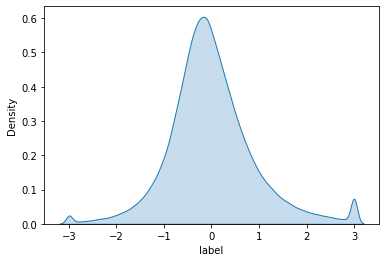

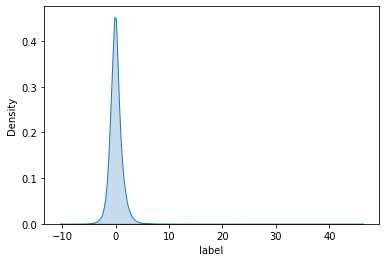

norm data done 

all works done 



,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount51,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60
count,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,...,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000
mean,0.004864,0.004706,0.004499,0.004229,0.003815,0.003576,0.003326,0.003137,0.002915,0.002629,...,-0.042320,-0.042312,-0.042339,-0.042371,-0.042382,-0.042427,-0.042444,-0.042481,-0.042546,-0.042623
std,0.939242,0.937807,0.938075,0.938857,0.940087,0.940261,0.940946,0.942728,0.943983,0.944755,...,0.763271,0.763121,0.762851,0.762358,0.761908,0.761729,0.761352,0.760852,0.760022,0.758771
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-0.866692,-0.794467,-0.790496,-0.788564,-0.788675,-0.797058,-0.790408,-0.834285,-0.768228,-0.811923
25%,-0.496842,-0.500554,-0.502784,-0.508470,-0.514417,-0.519034,-0.521277,-0.528964,-0.533077,-0.534961,...,-0.451021,-0.450863,-0.450534,-0.450303,-0.450107,-0.449879,-0.449257,-0.448740,-0.448486,-0.447673
50%,0.059407,0.055797,0.054986,0.053984,0.052128,0.051447,0.051558,0.051919,0.051437,0.051838,...,-0.348774,-0.348307,-0.348131,-0.347944,-0.347455,-0.347721,-0.347596,-0.346821,-0.346067,-0.344739
75%,0.554828,0.553338,0.554440,0.557270,0.560307,0.562767,0.567569,0.571369,0.576129,0.578880,...,-0.006367,-0.006097,-0.006390,-0.007421,-0.007732,-0.007917,-0.008200,-0.008316,-0.009396,-0.010947
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [5]:
# 先拆分出测试集，然后做特征工程、数据清洗，最后可以根据mutual information score选择特征

X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]

# 使用auto_process()自动处理训练集和验证集(将在以后的版本完善拆分数据集的函数，使其能够同时处理训练、验证和测试集)
# select需要消耗大量时间，但可以过滤掉噪声。使用时需要在时间开销和模型性能之间权衡
x_train, x_valid, y_train, y_valid, _, __ = scutquant.auto_process(X, 'label', groupby='instrument', datetime='datetime', 
                                                                         select=False, orth=False, label_norm=True)
x_train.describe()

In [6]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = scutquant.zscorenorm(x_test, x_test.groupby("datetime").mean(), x_test.groupby("datetime").std())

ymean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
ystd = y_test.groupby("instrument").shift(2).groupby("datetime").std()
ymean.fillna(0, inplace=True)
ystd.fillna(1, inplace=True)

In [7]:
# 拟合模型
model1 = scutquant.auto_lgbm(x_train, y_train, x_valid, y_valid)
model2 = scutquant.auto_lrg(x_train, y_train,  method='ridge')

pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred = []
for i in range(len(pred1)):
    pred.append(0.5 * pred1[i] + 0.5 * pred2[i])
pred = pd.DataFrame(pred, columns=["predict"], index=x_test.index)
pred["predict"] += ymean
pred["predict"] *= ystd
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.821057	valid's l2: 1.47173
Early stopping, best iteration is:
[7]	train's l2: 0.82303	valid's l2: 1.47152
ridge method will be used


,predict
count,70552.000000
mean,-0.000360
std,0.003867
min,-0.120214
25%,-0.000813
50%,-0.000271
75%,0.000276
max,0.108603


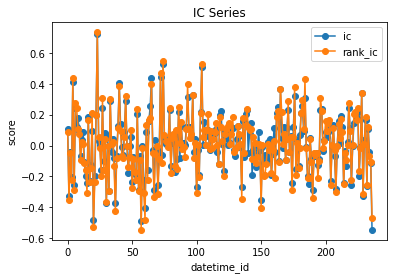

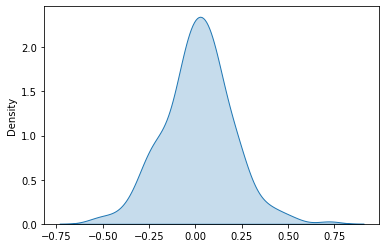

ic= 0.012736681866193603 icir= 0.06845854441305 rank_ic= 0.008671107679036493 rank_icir= 0.04332663785922023


-0.004418158303882709

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = scutquant.pearson_corr(pred.values, y_test)
r[0]

In [9]:
# 以下为回测部分
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, time='datetime', price='close', volume='volume')

Accuracy of Prediction: 0.5466605932927177


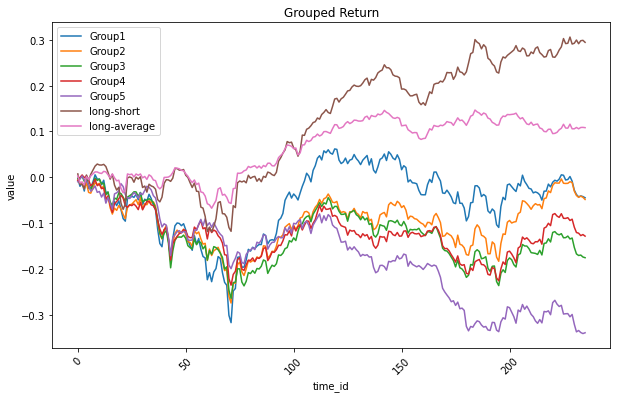

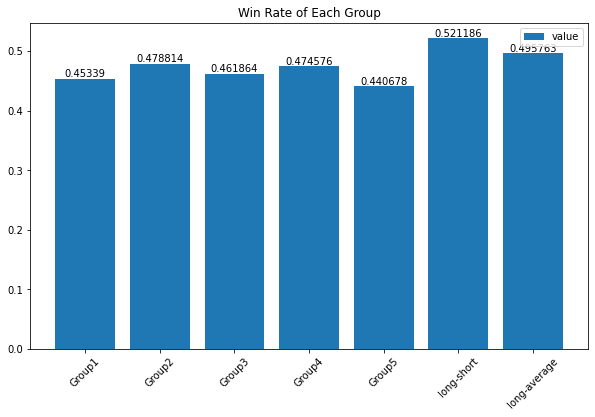

In [10]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

In [11]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": True,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": True,  # =True时，只做多不做空(在A股做空有一定的难度)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.01  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): -0.05579462131297017
std: 0.024123242919896083
E(r_benchmark): -0.12867191898052116
std_benchmark: 0.05329655828798661 

Cumulative Rate of Return: -0.08974272356041146
Cumulative Rate of Return(benchmark): -0.1858229210189083
Cumulative Excess Rate of Return: 0.09608019745849683 

Max Drawdown: -0.11669380539349428
Max Drawdown(benchmark): -0.23197087771901204 

Sharpe Ratio: -2.316306032291648
Sortino Ratio: 12.405170170238684
Information Ratio: 3.0210406581548006 

Pearson Correlation Coefficient Between Return and Benchmark: 0.9294191750434914
Profitable Days(%): 0.0


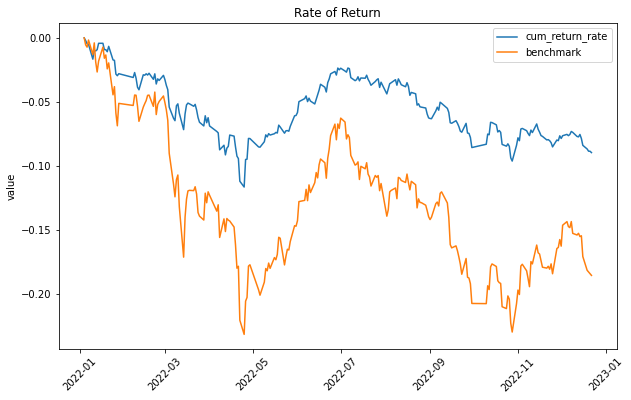

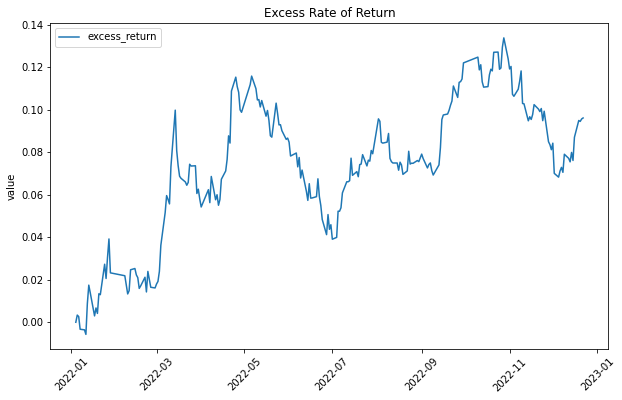

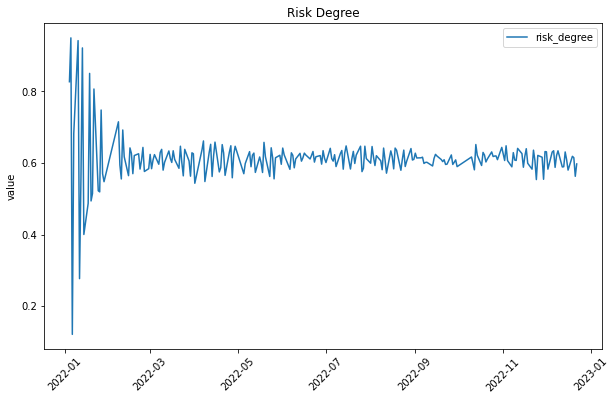

In [12]:
# 报告回测结果
# 对比2022年主动管理型基金的业绩，这表现算是在平均线以上
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
user_account.buy_hist # 查看下单历史(因为设置了buy_only, 卖单是空的，这里仅展示买单)

[{'600436.SH': 7577,
  '002568.SZ': 43639,
  '000301.SZ': 375624,
  '000596.SZ': 27726,
  '300760.SZ': 45836,
  '601888.SH': 34385,
  '600188.SH': 239456,
  '300751.SZ': 15625,
  '300142.SZ': 21066,
  '300316.SZ': 28359,
  '300919.SZ': 26916,
  '600406.SH': 15066,
  '601669.SH': 1717782,
  '300595.SZ': 23793,
  '688599.SH': 230751,
  '600886.SH': 39158,
  '000338.SZ': 44562,
  '601100.SH': 39531,
  '300496.SZ': 31279,
  '300661.SZ': 14735,
  '600031.SH': 19754,
  '603288.SH': 23958,
  '300274.SZ': 18398,
  '300957.SZ': 11341,
  '300759.SZ': 102076,
  '603259.SH': 61668,
  '002791.SZ': 24793,
  '300014.SZ': 8413,
  '300454.SZ': 16435,
  '601633.SH': 92343,
  '600795.SH': 25103,
  '000858.SZ': 4750,
  '002129.SZ': 95629,
  '002410.SZ': 20325,
  '002920.SZ': 53607,
  '300223.SZ': 49646,
  '300122.SZ': 32124,
  '300896.SZ': 14493,
  '601088.SH': 359630,
  '002371.SZ': 11301,
  '603369.SH': 84021,
  '603392.SH': 15384,
  '300601.SZ': 54694,
  '300207.SZ': 60925,
  '300750.SZ': 29295,
  '300